# Look at MEA recorded activity pre and post TTX

In [1]:
%load_ext autoreload
import sys
sys.path.append("/home/timsit/mecp2/python/")
import mea_util
import spike_detection as dspikes
import process_spikes as pspikes
import vizpikes 

import numpy as np
import xarray as xr
import pandas as pd

# Signal processing 
import scipy.signal as ssignal

# dashboard
import panel as pn
from panel.interact import fixed
import param

# plotting 
import matplotlib as mpl
import matplotlib.pyplot as plt
import sciplotlib.polish as splpolish 
import sciplotlib.style as splstyle

import os 
import glob
import pickle as pkl
import h5py
# For downloading df to csv 
from io import StringIO

# analysis 
# 
# import process_spikes as pspikes



# Network
import networkx as nx

# Bokeh 
import bokeh as bk
from bokeh.io import output_file, show
from bokeh.models import (BoxSelectTool, Circle, EdgesAndLinkedNodes, HoverTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool, StaticLayoutProvider)
from bokeh.palettes import Spectral4
from bokeh.plotting import from_networkx

pn.extension()

SyntaxError: positional argument follows keyword argument (spike_detection.py, line 299)

## Load data

In [19]:
pre_ttx_path = '/home/timsit/mecp2/data/MPT200209_3A_DIV12.mat'
ttx_path = '/home/timsit/mecp2/data/MPT200209_3A_DIV12_TTX.mat'
file_path_list = [pre_ttx_path, ttx_path]

In [3]:
pre_ttx_data = mea_util.hdf_loadmat(pre_ttx_path)

/home/timsit/mecp2/python/mea_util.py:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(mat_filepath)


In [4]:
ttx_data = mea_util.hdf_loadmat(ttx_path)

In [5]:
%autoreload
pre_ttx_ds = mea_util.mea_mat_to_xarray(pre_ttx_data, file_name=os.path.basename(pre_ttx_path.split('.')[0]))
ttx_ds = mea_util.mea_mat_to_xarray(ttx_data, file_name=os.path.basename(ttx_path.split('.')[0]))

## Plot the raw data

In [6]:
pre_ttx_raw_traces = pre_ttx_data['dat']
ttx_raw_traces = ttx_data['dat']

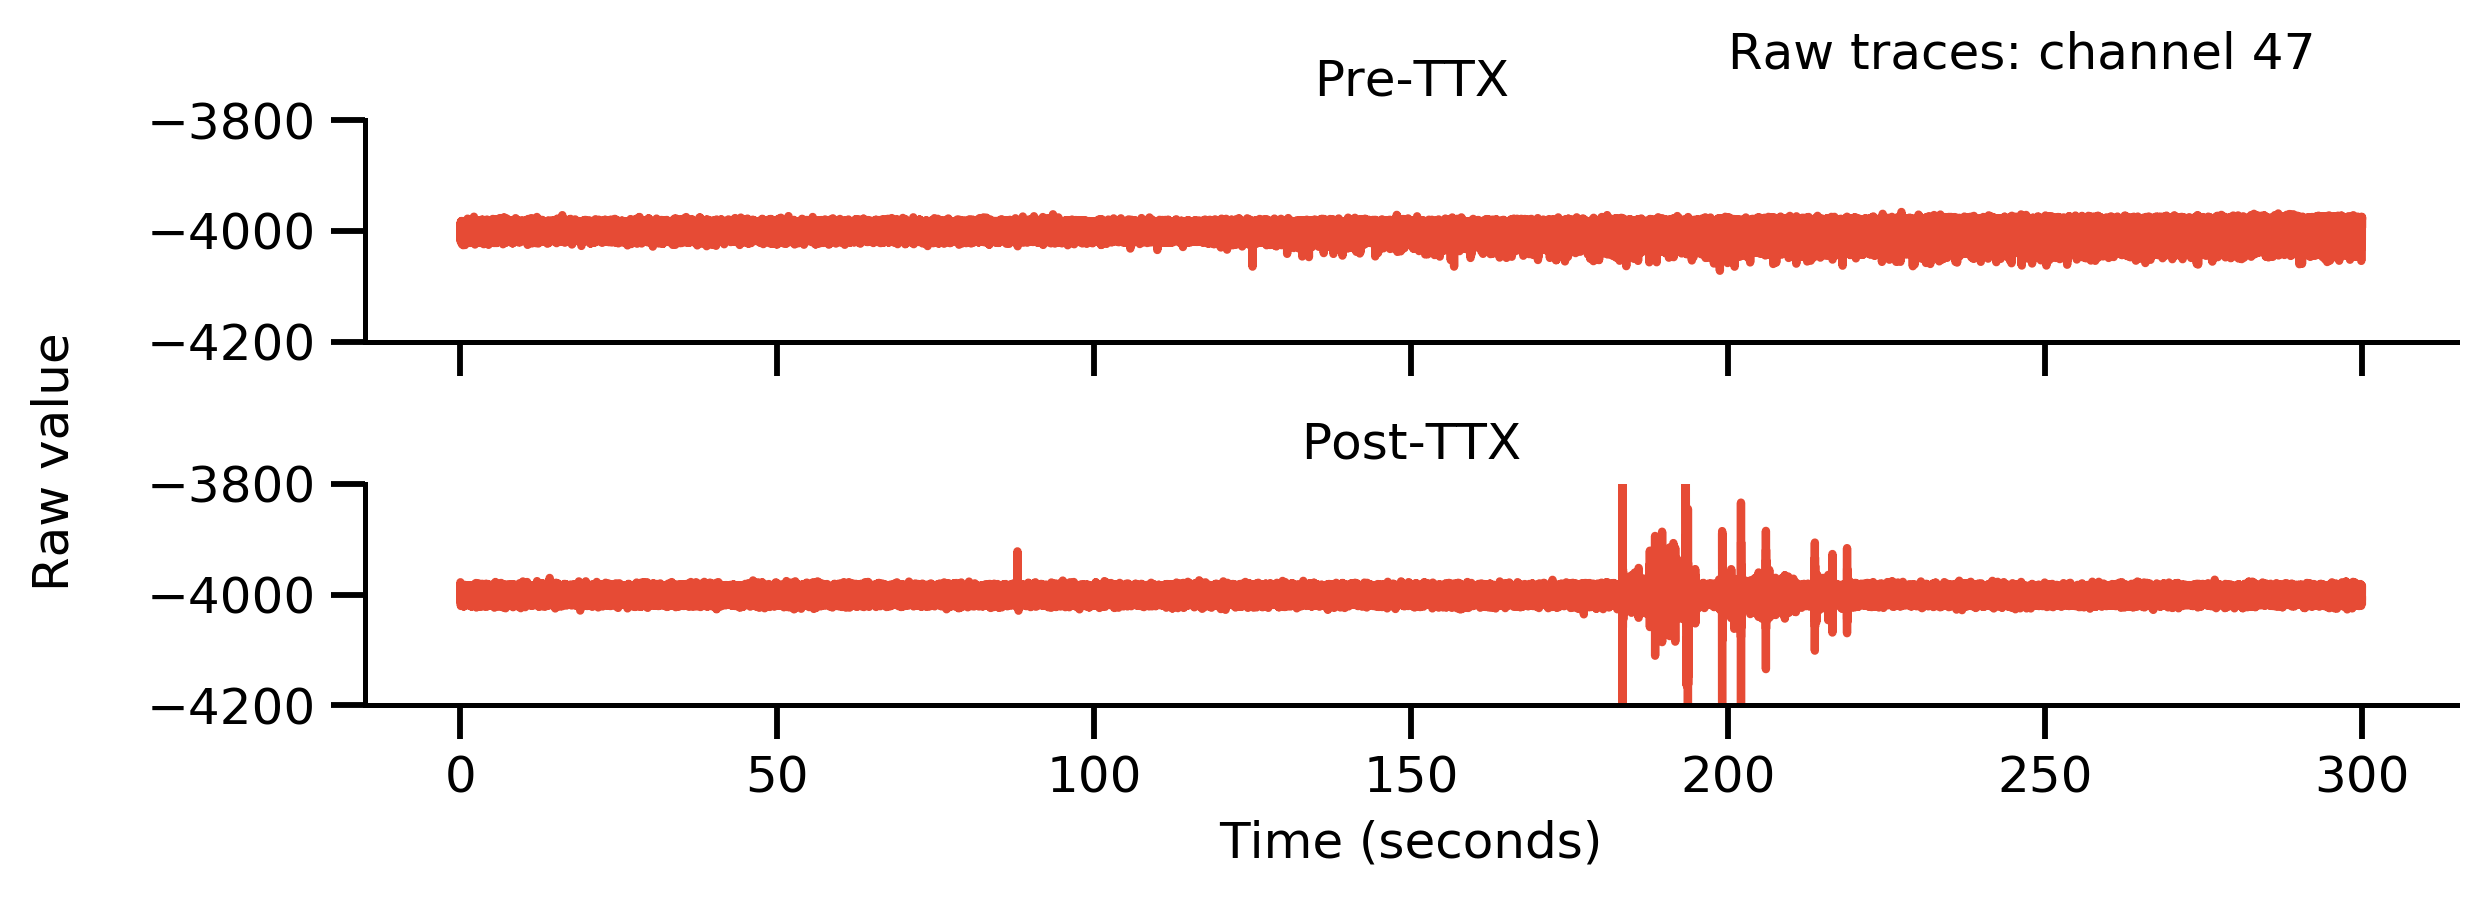

In [7]:
with plt.style.context(splstyle.get_style('nature-reviews')):
    fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
    fig.set_size_inches(8, 3)

    channel_idx_to_plot = 0

    axs[0].plot(pre_ttx_ds['Time'], pre_ttx_ds.isel(Channel=channel_idx_to_plot)['raw'])
    axs[1].plot(ttx_ds['Time'], ttx_ds.isel(Channel=channel_idx_to_plot)['raw'])
    
    axs[0].set_title('Pre-TTX', size=12)
    axs[1].set_title('Post-TTX', size=12)
    
    axs[0].set_ylim([-4200, -3800])

    axs[1].set_xlabel('Time (seconds)', size=12)
    
    fig.tight_layout()
    fig.suptitle('Raw traces: channel %.f' % pre_ttx_ds.isel(Channel=channel_idx_to_plot)['Channel'],
                x=0.8)
    
    fig.text(-0.03, 0.5, 'Raw value', va='center', rotation=90, size=12)

### Loop through all electrodes to do the above 

In [8]:
for channel in pre_ttx_ds['Channel']:
    
    with plt.style.context(splstyle.get_style('nature-reviews')):
        fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
        fig.set_size_inches(8, 3)

        channel_idx_to_plot = 0

        axs[0].plot(pre_ttx_ds['Time'], pre_ttx_ds.sel(Channel=channel)['raw'])
        axs[1].plot(ttx_ds['Time'], ttx_ds.sel(Channel=channel)['raw'])

        axs[0].set_title('Pre-TTX', size=12)
        axs[1].set_title('Post-TTX', size=12)

        axs[0].set_ylim([-4200, -3800])

        axs[1].set_xlabel('Time (seconds)', size=12)

        fig.tight_layout()
        fig.suptitle('Raw traces: channel %.f' % channel,
                    x=0.8)

        fig.text(-0.03, 0.5, 'Raw value', va='center', rotation=90, size=12)
        
        fig_folder = '/home/timsit/mecp2/python/figures/pre-post-ttx-comparison/raw_traces/'
        fig_name = 'electrode_%.f' % channel
        fig_ext = '.png'
        fig.savefig(os.path.join(fig_folder, fig_name + fig_ext), dpi=300, bbox_inches='tight')
        fig.clf()
        plt.close(fig)

## Filter the data

### Use the same filter as used in the wavelet method 

In [15]:
%autoreload

# pre_ttx_raw_filtered = dspikes.filter_raw_traces(pre_ttx_raw_traces)
pre_ttx_filtered_trace = dspikes.filter_raw_traces(pre_ttx_ds['raw'])
pre_ttx_ds = pre_ttx_ds.assign({'filtered': (['Channel', 'Time'], pre_ttx_filtered_trace)})

ttx_ds_filtered_trace = dspikes.filter_raw_traces(ttx_ds['raw'])
ttx_ds = ttx_ds.assign({'filtered': (['Channel', 'Time'], ttx_ds_filtered_trace)})

In [26]:
ttx_filtered = dspikes.filter_raw_traces(ttx_raw_traces)

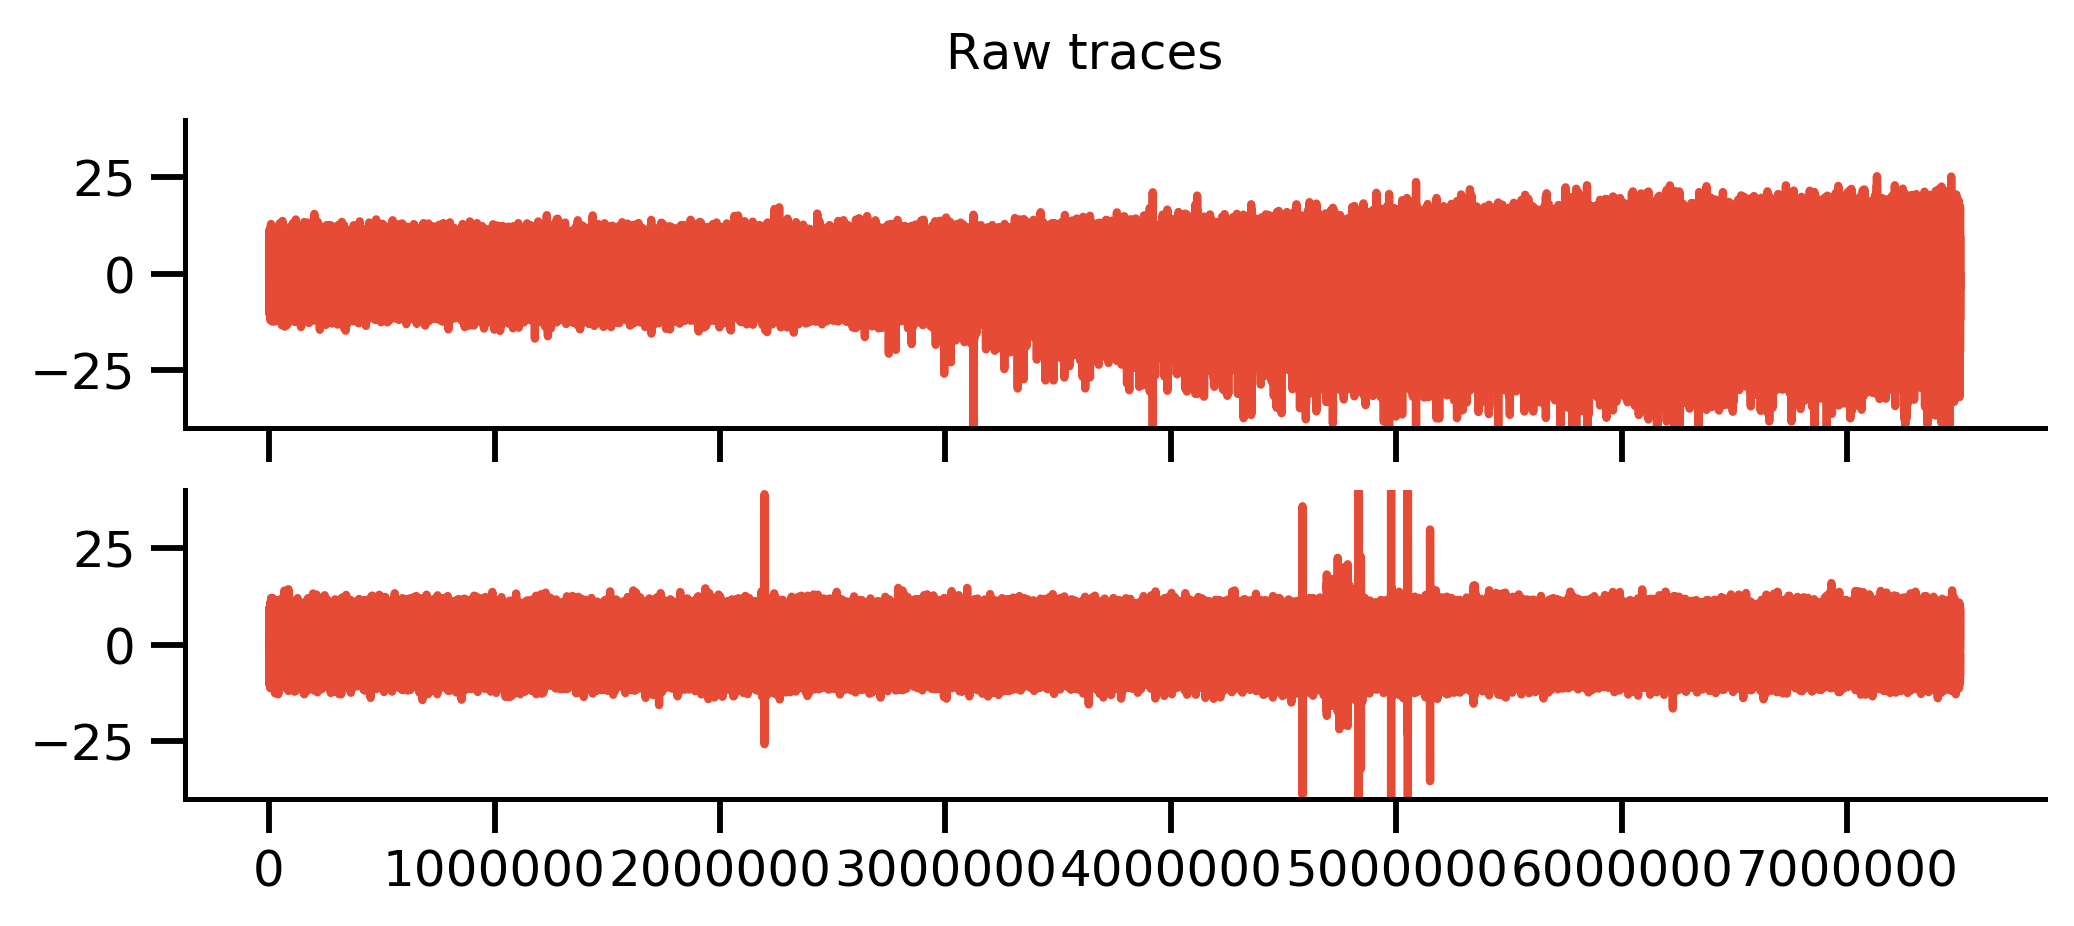

In [28]:
with plt.style.context(splstyle.get_style('nature-reviews')):
    fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
    fig.set_size_inches(8, 3)

    channel_idx_to_plot = 0

    axs[0].plot(pre_ttx_raw_filtered[channel_idx_to_plot, :])
    axs[1].plot(ttx_filtered[channel_idx_to_plot, :])
    
    axs[0].set_ylim([-40, 40])

    fig.suptitle('Raw traces')

### Loop through all electrodes and plot filtered trace

In [18]:
custom_xlim = [150, 160]

for channel in pre_ttx_ds['Channel']:
    
    with plt.style.context(splstyle.get_style('nature-reviews')):
        fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
        fig.set_size_inches(8, 3)

        channel_idx_to_plot = 0

        axs[0].plot(pre_ttx_ds['Time'], pre_ttx_ds.sel(Channel=channel)['filtered'], linewidth=1)
        axs[1].plot(ttx_ds['Time'], ttx_ds.sel(Channel=channel)['filtered'], linewidth=1)

        axs[0].set_title('Pre-TTX', size=12)
        axs[1].set_title('Post-TTX', size=12)

        axs[0].set_ylim([-40, 40])
        
        if custom_xlim is not None:
            axs[0].set_xlim(custom_xlim)

        axs[1].set_xlabel('Time (seconds)', size=12)

        fig.tight_layout()
        fig.suptitle('Filtered traces: channel %.f' % channel,
                    x=0.8)

        fig.text(-0.03, 0.5, 'Filtered value', va='center', rotation=90, size=12)
        
        fig_folder = '/home/timsit/mecp2/python/figures/pre-post-ttx-comparison/filtered_traces/'
        if not os.path.exists(fig_folder):
            os.mkdir(fig_folder)
        
        fig_name = 'electrode_%.f_x_from_%.f_to_%.f' % (channel, custom_xlim[0], custom_xlim[1])
        fig_ext = '.png'
        fig.savefig(os.path.join(fig_folder, fig_name + fig_ext), dpi=300, bbox_inches='tight')
        fig.clf()
        plt.close(fig)

## Run spyking circus to do spike detection

### Convert files to numpy arrays

In [20]:
for mat_filepath in file_path_list: 
    mea_util.mea_mat_to_numpy(mat_filepath)

/home/timsit/mecp2/python/mea_util.py:17: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(mat_filepath)


File succesfully saved to /home/timsit/mecp2/data/MPT200209_3A_DIV12.npy
File succesfully saved to /home/timsit/mecp2/data/MPT200209_3A_DIV12_TTX.npy


## Load and look at spike detection results: pre and post TTX

In [20]:
def load_spyking_circus_results(spyking_circus_output_dir):
    """
    Loads spikes detected from spyking circus.
    Parameters
    ----------
    spyking_circus_output_dir

    Returns
    -------

    """

    result_file = glob.glob(os.path.join(spyking_circus_output_dir, '*.result-merged.hdf5'))[0]
    spike_sorting_result = h5py.File(result_file, 'r')
    
    cluster_file = glob.glob(os.path.join(spyking_circus_output_dir, '*clusters-merged.hdf5'))[0]
    cluster = h5py.File(cluster_file, 'r')
    template_to_electrode_map = cluster['electrodes'][()]

    # Make dataframe of the spike of each template
    template_spiketime_dict = dict()
    template_spiketime_dict['template'] = list()
    template_spiketime_dict['spiketime'] = list()
    template_spiketime_dict['electrode'] = list()

    fs = 25000
    for template_n, template_field in enumerate(spike_sorting_result['spiketimes']):
        template_spiketimes = spike_sorting_result['spiketimes'][template_field][()]
        template_spiketime_dict['template'].extend(np.repeat(template_n, len(template_spiketimes)))
        template_spiketime_dict['spiketime'].extend(template_spiketimes / fs)

        # Add electrode number
        electrode_num = template_to_electrode_map[template_n]
        template_spiketime_dict['electrode'].extend(np.repeat(electrode_num, len(template_spiketimes)))

    template_spiketime_df = pd.DataFrame.from_dict(template_spiketime_dict)

    # Count number of spike per electrode
    spyking_circus_spike_count = template_spiketime_df.groupby('electrode').count()['spiketime']
    spike_count_per_electrode = add_zero_spikecount(spyking_circus_spike_count)

    return template_spiketime_df, spike_count_per_electrode


def add_zero_spikecount(spyking_circus_spike_count, num_electrode=60):

    for electrode in np.arange(num_electrode):
        if electrode not in spyking_circus_spike_count.index:
            spyking_circus_spike_count.loc[electrode] = 0
            # zero_spike_electrode = pd.DataFrame([0])
            # zero_spike_electrode.name = electrode
            # spyking_circus_spike_count = spyking_circus_spike_count.append(zero_spike_electrode)

    return spyking_circus_spike_count.sort_index()

In [28]:
%autoreload
# load spyking circus data 
pre_ttx_spyking_circus_output_dir = '/home/timsit/mecp2/python/spike_detection/MPT200209_3A_DIV12/MPT200209_3A_DIV12/'
pre_ttx_spike_df, pre_ttx_spike_count = load_spyking_circus_results(pre_ttx_spyking_circus_output_dir)


post_ttx_spyking_circus_output_dir = '/home/timsit/mecp2/python/spike_detection/MPT200209_3A_DIV_12_TTX/MPT200209_3A_DIV12_TTX/'
post_ttx_spike_df, post_ttx_spike_count = load_spyking_circus_results(post_ttx_spyking_circus_output_dir)

In [25]:
# quick hack to get the channel numbers, should include this to files
raw_data_file = '/home/timsit/mecp2/data/PAT200219_2C_DIV170002.mat'
raw_data = mea_util.hdf_loadmat(raw_data_file)
channel_num = raw_data['channels'][0]
channel_idx = np.argsort(channel_num)
sorted_channel_num = channel_num[channel_idx]

/home/timsit/mecp2/python/mea_util.py:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(mat_filepath)


/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/timsit/.conda/envs/mecp2/lib/pyth

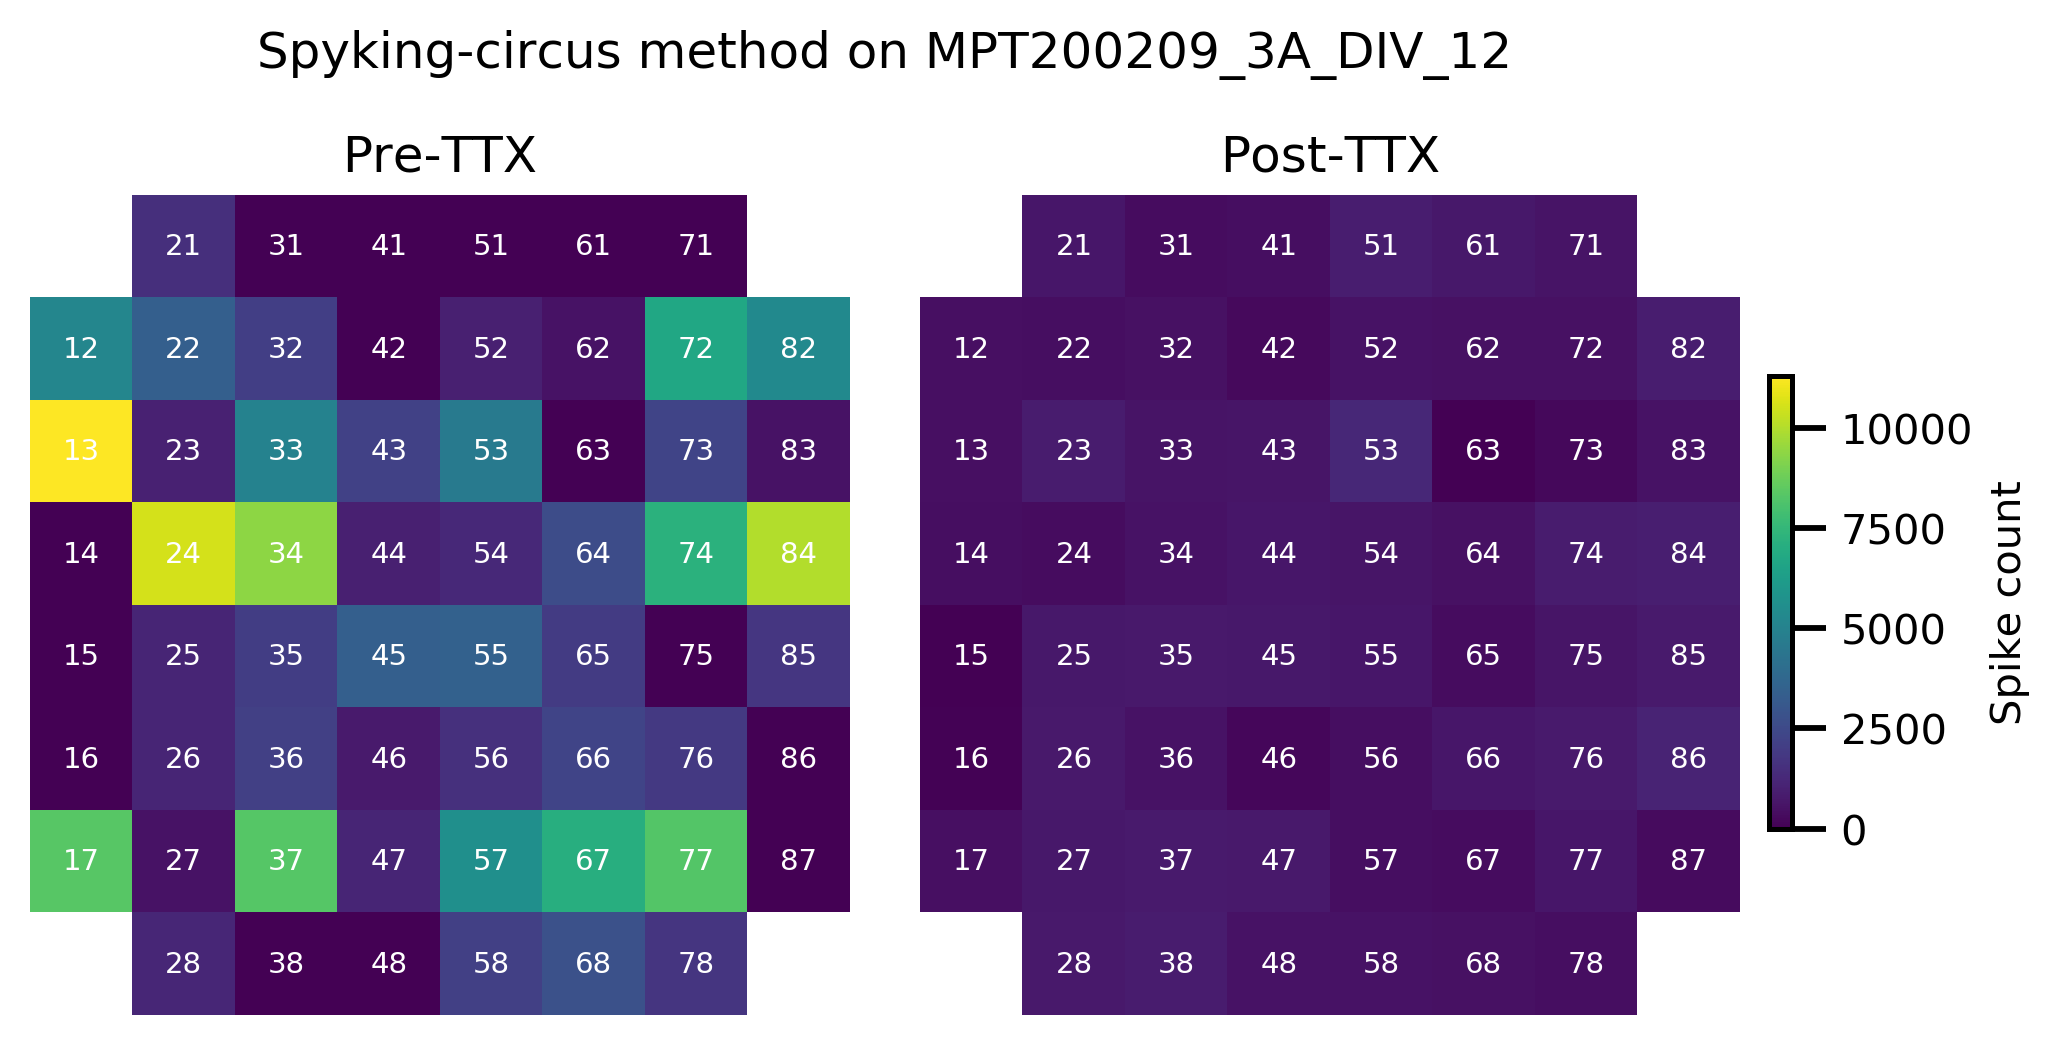

In [93]:
%autoreload
add_electrode_num_text = False

with plt.style.context(splstyle.get_style('nature-reviews')):
    fig, axs = plt.subplots(1, 2)
    
    vmin = np.nanmin(pre_ttx_spyking_circus_spike_sum_matrix)
    vmax = np.nanmax(pre_ttx_spyking_circus_spike_sum_matrix)
    
    pre_ttx_spyking_circus_spike_sum_matrix = mea_util.make_grid_matrix(pre_ttx_spike_count.values)
    im0 = axs[0].imshow(pre_ttx_spyking_circus_spike_sum_matrix, vmin=vmin, vmax=vmax)
    
    # fig.colorbar(ax=axs[0])
    post_ttx_spyking_circus_spike_sum_matrix = mea_util.make_grid_matrix(post_ttx_spike_count.values)
    im1 = axs[1].imshow(post_ttx_spyking_circus_spike_sum_matrix, vmin=vmin, vmax=vmax)
    
    axs[0].set_title('Pre-TTX', size=12)
    axs[1].set_title('Post-TTX', size=12)
    
    grid_channel_num_matrix = mea_util.make_grid_matrix(sorted_channel_num)
    fig, axs[0] = vizpikes.plot_grid_layout(fig=fig, ax=axs[0], grid_channel_num_matrix=grid_channel_num_matrix,
                                  text_color='white', text_size=7)
    
    fig, axs[1] = vizpikes.plot_grid_layout(fig=fig, ax=axs[1], grid_channel_num_matrix=grid_channel_num_matrix,
                                  text_color='white', text_size=7)
    
    axs[0].axis('off')
    axs[1].axis('off')
    
    cbar = fig.colorbar(im0, ax=axs[:], shrink=0.5, anchor=(2, 0.5))
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label(label='Spike count', size=10)
    
    fig_folder = '/home/timsit/mecp2/python/figures/spike_detection'
    fig_name = 'MPT200209_3A_DIV_12_spike_count_spyking_circus_pre_vs_post_TTX'
    fig_ext = '.png'
    
    fig.suptitle('Spyking-circus method on MPT200209_3A_DIV_12', size=12)
    fig.tight_layout()
    fig.savefig(os.path.join(fig_folder, fig_name), dpi=300, bbox_inches='tight')

#### CWT Method

In [43]:
cwt_spike_file = '/home/timsit/mecp2/python/spike_detection/MPT200209_3A_DIV_12_cwt_L0_spikes.mat'
cwt_pre_ttx_spike = mea_util.hdf_loadmat(cwt_spike_file)['spike_matrix']

/home/timsit/mecp2/python/mea_util.py:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(mat_filepath)


In [51]:
np.sum(cwt_pre_ttx_spike)

974107.0

In [44]:
cwt_TTX_spike_file = '/home/timsit/mecp2/python/spike_detection/MPT200209_3A_DIV_12_TTX_cwt_L0_spikes.mat'
cwt_post_ttx_spike = mea_util.hdf_loadmat(cwt_TTX_spike_file)['spike_matrix']

In [59]:
channel_num = raw_data['channels'][0]
channel_idx = np.argsort(channel_num)
sorted_channel_num = channel_num[channel_idx]

# Pre-TTX file
cwt_pre_ttx_spike_ordered = cwt_pre_ttx_spike.T[:, channel_idx]

cwt_pre_ttx_spike_count_ordered = np.sum(cwt_pre_ttx_spike_ordered, axis=0)

# Post-TTX file
cwt_post_ttx_spike_ordered = cwt_post_ttx_spike.T[:, channel_idx]

cwt_post_ttx_spike_count_ordered = np.sum(cwt_post_ttx_spike_ordered, axis=0)



/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/timsit/.conda/envs/mecp2/lib/pyth

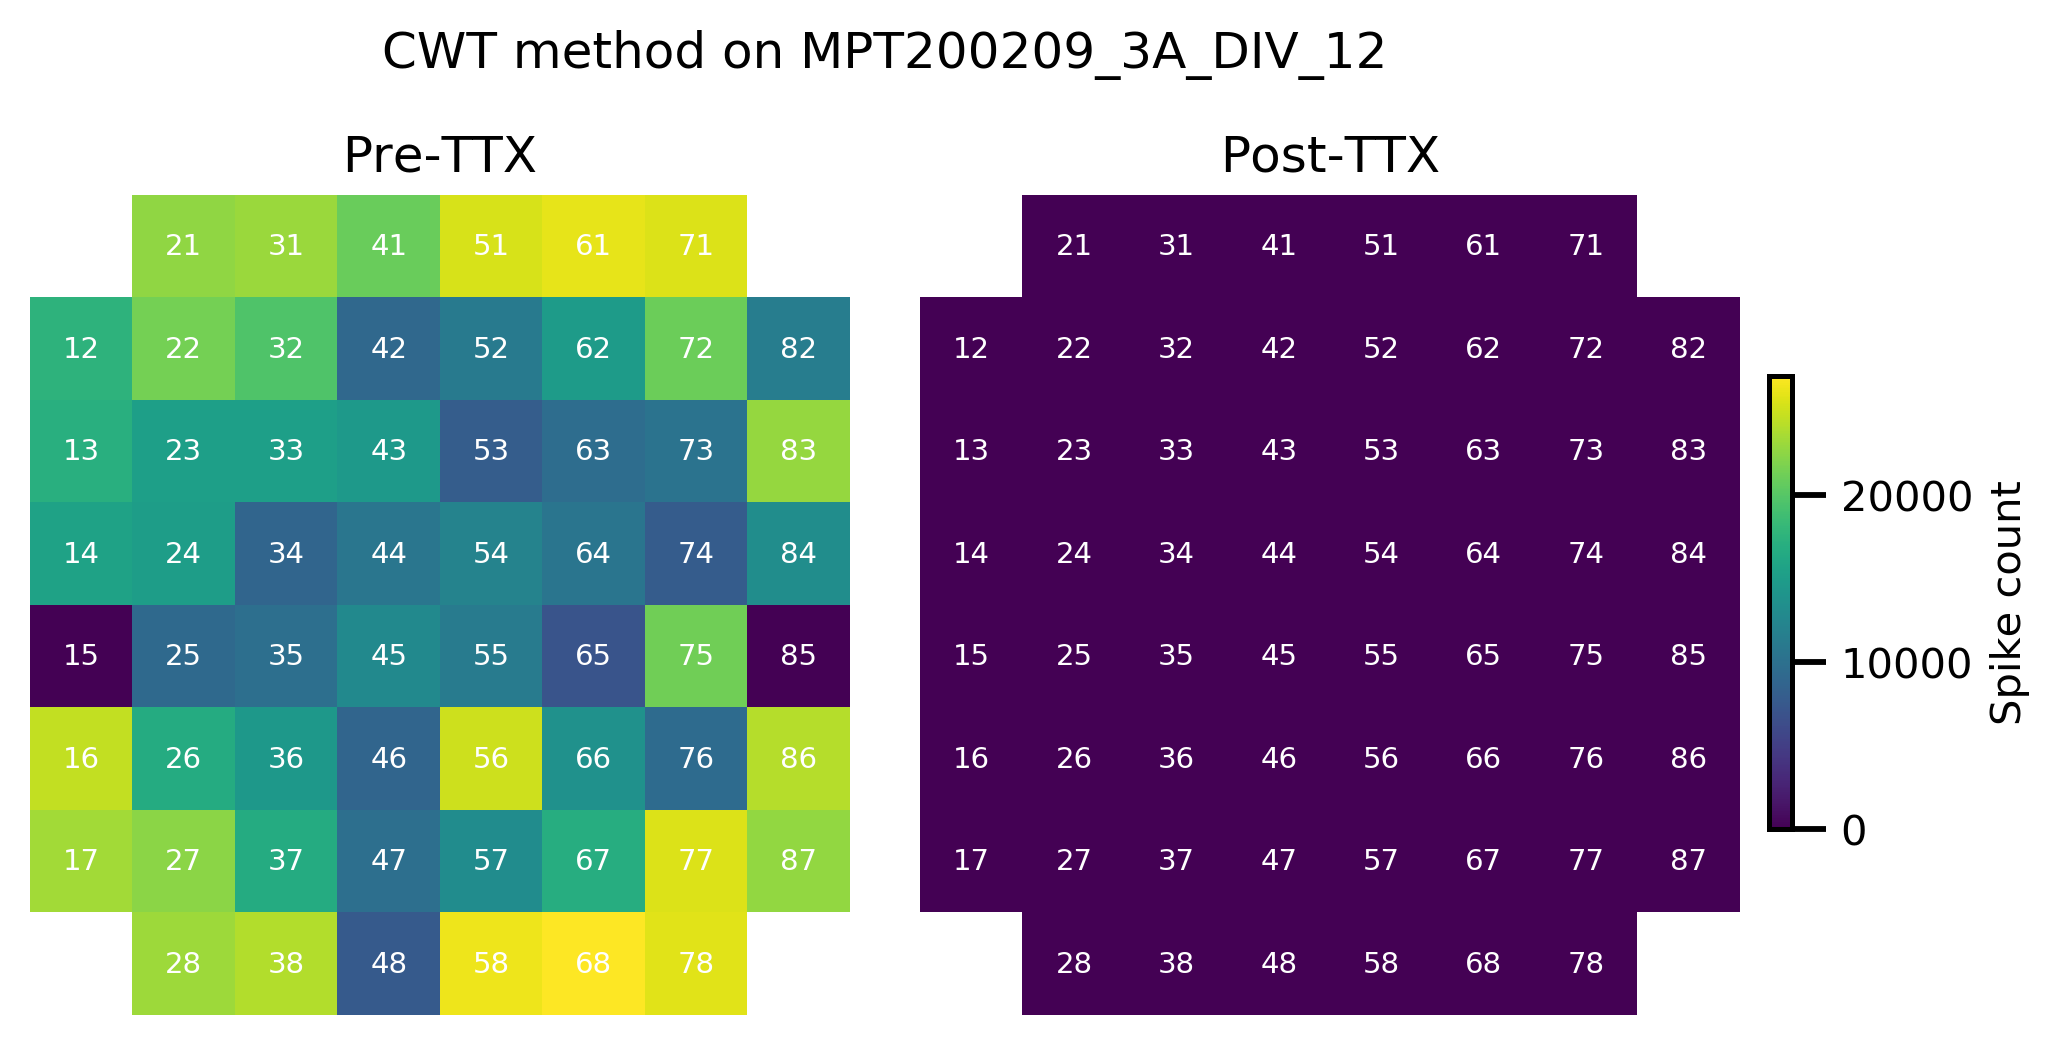

In [90]:
%autoreload
add_electrode_num_text = False

with plt.style.context(splstyle.get_style('nature-reviews')):
    fig, axs = plt.subplots(1, 2)
    
    vmin = np.nanmin(cwt_pre_ttx_spike_sum_matrix)
    vmax = np.nanmax(cwt_pre_ttx_spike_sum_matrix)
    
    cwt_pre_ttx_spike_sum_matrix = mea_util.make_grid_matrix(cwt_pre_ttx_spike_count_ordered)
    im0 = axs[0].imshow(cwt_pre_ttx_spike_sum_matrix, vmin=vmin, vmax=vmax)
    

    cwt_post_ttx_spike_sum_matrix = mea_util.make_grid_matrix(cwt_post_ttx_spike_count_ordered)
    im1 = axs[1].imshow(cwt_post_ttx_spike_sum_matrix, vmin=vmin, vmax=vmax)
    

    axs[0].set_title('Pre-TTX', size=12)
    axs[1].set_title('Post-TTX', size=12)
    
    grid_channel_num_matrix = mea_util.make_grid_matrix(sorted_channel_num)
    fig, axs[0] = vizpikes.plot_grid_layout(fig=fig, ax=axs[0], grid_channel_num_matrix=grid_channel_num_matrix,
                                  text_color='white', text_size=7)
    
    fig, axs[1] = vizpikes.plot_grid_layout(fig=fig, ax=axs[1], grid_channel_num_matrix=grid_channel_num_matrix,
                                  text_color='white', text_size=7)
    
    axs[0].axis('off')
    axs[1].axis('off')
    
    cbar = fig.colorbar(im0, ax=axs[:], shrink=0.5, anchor=(2, 0.5))
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label(label='Spike count', size=10)
    
    fig.suptitle('CWT method on MPT200209_3A_DIV_12', size=12)
    fig.tight_layout()
    
    fig_folder = '/home/timsit/mecp2/python/figures/spike_detection'
    fig_name = 'MPT200209_3A_DIV_12_spike_count_cwt_pre_vs_post_TTX'
    fig_ext = '.png'
    fig.savefig(os.path.join(fig_folder, fig_name), dpi=300, bbox_inches='tight')

### Compare electrode-electrode comparison 

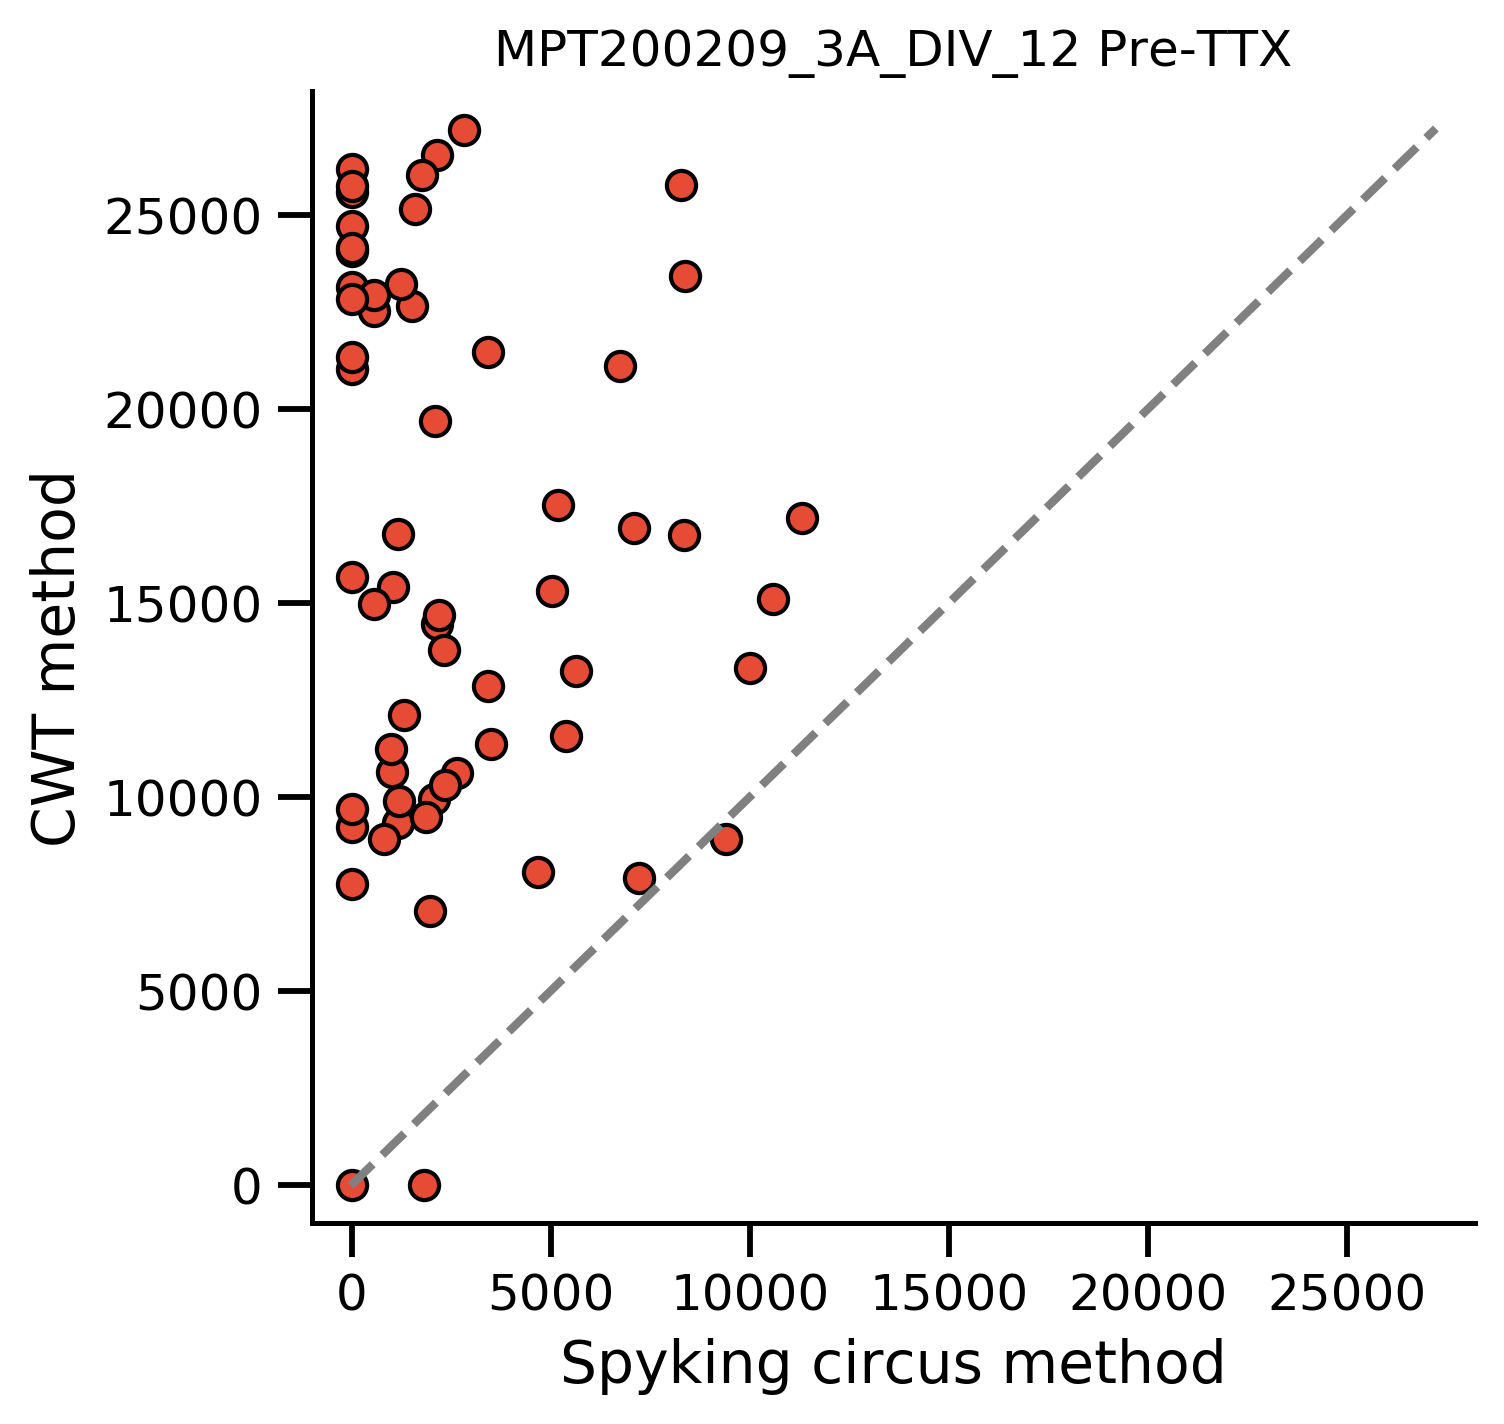

In [91]:
with plt.style.context(splstyle.get_style('nature-reviews')):
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)
    ax.scatter(pre_ttx_spike_count.values, cwt_pre_ttx_spike_count_ordered)
    ax.set_xlabel('Spyking circus method')
    ax.set_ylabel('CWT method')
    
    global_min = np.min(np.concatenate([pre_ttx_spike_count.values, cwt_pre_ttx_spike_count_ordered]))
    global_max = np.max(np.concatenate([pre_ttx_spike_count.values, cwt_pre_ttx_spike_count_ordered]))
    
    unity_values = np.linspace(global_min - min_offset, global_max + max_offset, 1000)
    ax.plot(unity_values, unity_values, linestyle='--', color='grey')
    
    min_offset = 1000
    max_offset = 1000
    
    ax.set_xlim([global_min - min_offset, global_max + max_offset])
    ax.set_ylim([global_min - min_offset, global_max + max_offset])
    
    ax.set_title('MPT200209_3A_DIV_12 Pre-TTX', size=12)
    
    fig_folder = '/home/timsit/mecp2/python/figures/spike_detection'
    fig_name = 'MPT200209_3A_DIV_12_spike_count_pre_TTX_cwt_vs_spyking_unity_plot'
    fig_ext = '.png'
    fig.savefig(os.path.join(fig_folder, fig_name), dpi=300, bbox_inches='tight')

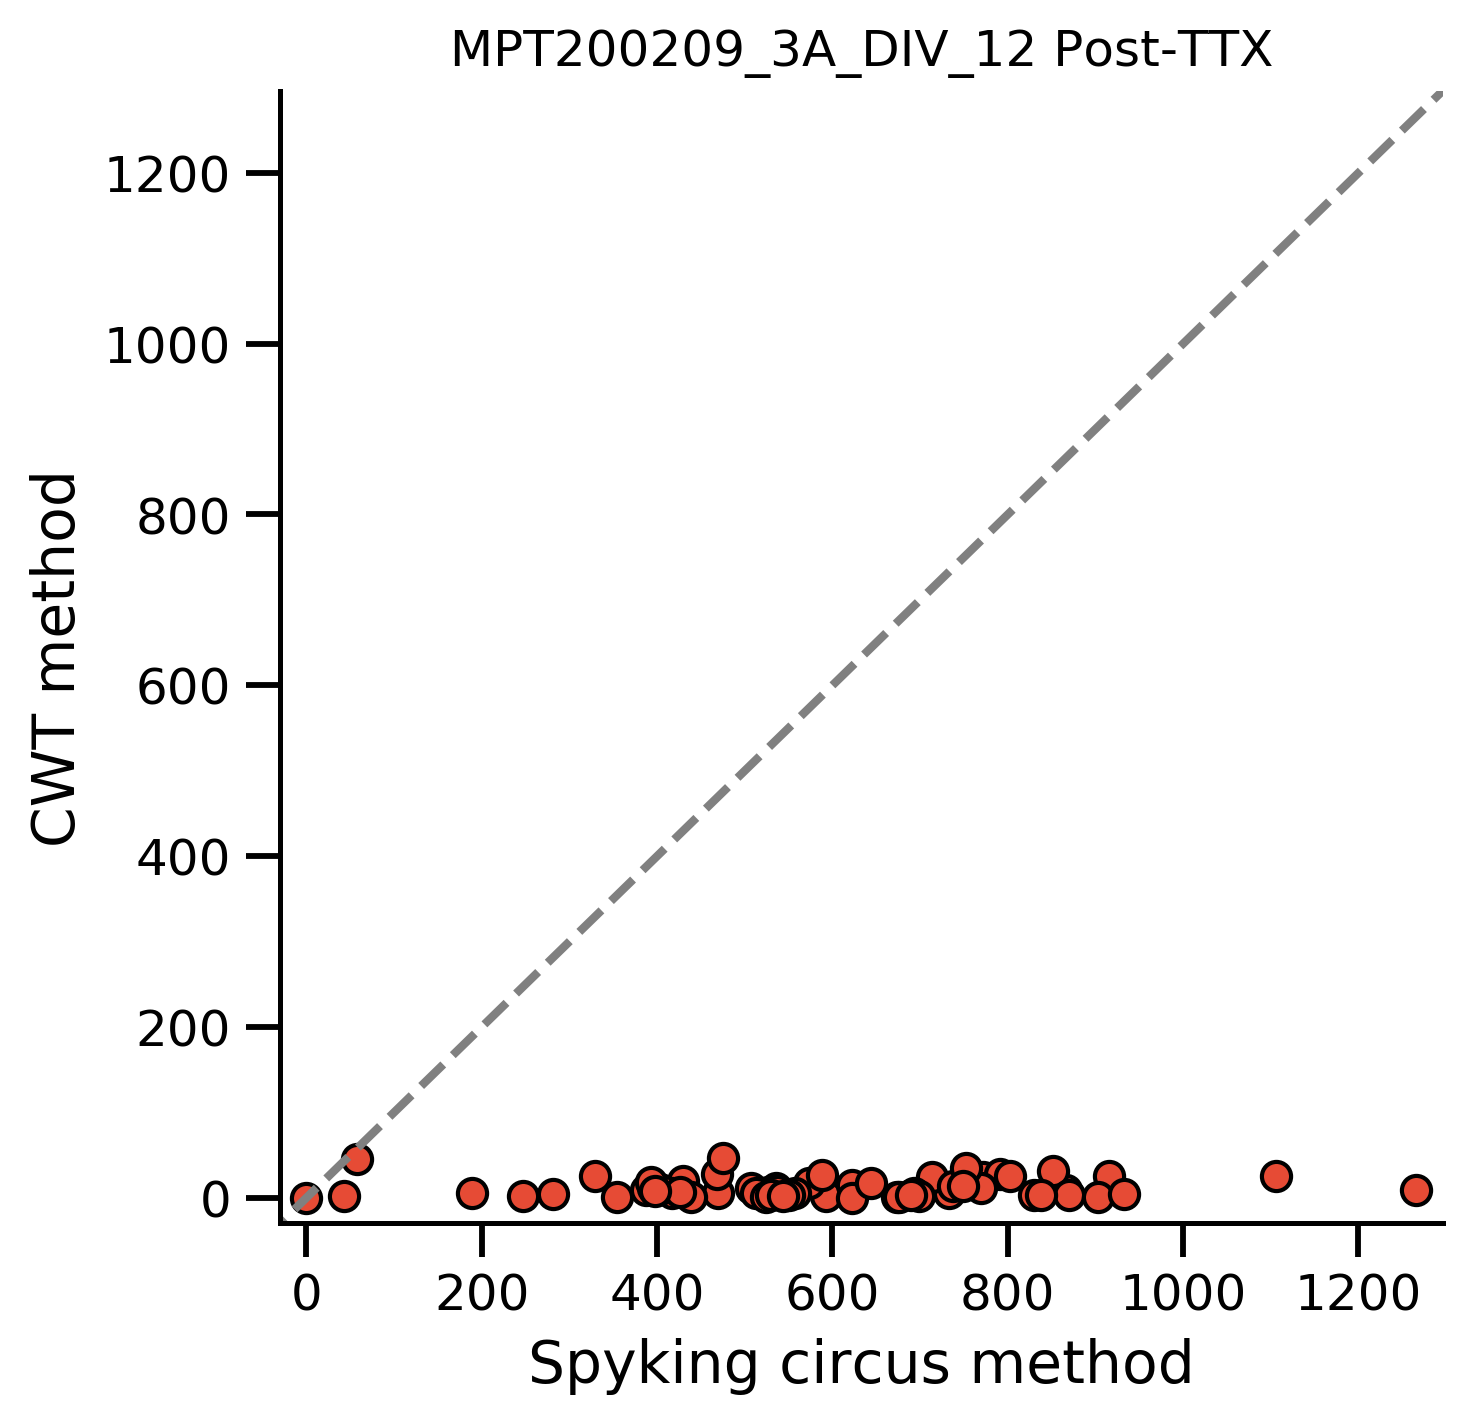

In [92]:
with plt.style.context(splstyle.get_style('nature-reviews')):
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)
    ax.scatter(post_ttx_spike_count.values, cwt_post_ttx_spike_count_ordered)
    ax.set_xlabel('Spyking circus method')
    ax.set_ylabel('CWT method')
    
    global_min = np.min(np.concatenate([post_ttx_spike_count.values, cwt_post_ttx_spike_count_ordered]))
    global_max = np.max(np.concatenate([post_ttx_spike_count.values, cwt_post_ttx_spike_count_ordered]))
    
    unity_values = np.linspace(global_min - min_offset, global_max + max_offset, 1000)
    ax.plot(unity_values, unity_values, linestyle='--', color='grey')
    
    min_offset = 30
    max_offset = 30
    
    ax.set_xlim([global_min - min_offset, global_max + max_offset])
    ax.set_ylim([global_min - min_offset, global_max + max_offset])
    
    ax.set_title('Post-TTX', size=12)
    
    
    ax.set_title('MPT200209_3A_DIV_12 Post-TTX', size=12)
    
    fig_folder = '/home/timsit/mecp2/python/figures/spike_detection'
    fig_name = 'MPT200209_3A_DIV_12_spike_count_post_TTX_cwt_vs_spyking_unity_plot'
    fig_ext = '.png'
    fig.savefig(os.path.join(fig_folder, fig_name), dpi=300, bbox_inches='tight')